In [1]:
import UMIsimulator.ampcycle as ampcycle
import UMIsimulator.dedup as dedup
import numpy as np
import UMIsimulator.simulator as sim
%load_ext line_profiler

In [128]:
import UMIsimulator.dedup as dedup
from collections import Counter

umis = ['GTCGATT','CTGTATT','GTTTTAG','GGGAACA','AAGGTAC','TATGAGG','CCCCTTG','GGCCCGG','CCCAAAC','GACATCC']
counts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
c = sum([[s] * n for s, n in zip(umis, counts)], [])
umis_amplified = Counter(c)
umis_amplified

dedup.dedup_naive(umis_amplified)

np.random.seed(123)
pool = ampcycle.Pool()
pool.createUMIsWithBias(100, 0.7, 1, 0.001)
pool.SimulateCycleWithErrors()
pool.PCRcyclesWithErrorsAndBias(5)
count = dedup.dedup_dir_adj(pool.umis_amplified)
count



99

In [5]:
%%time
dedup_methods = ["unique", "dir_adj"]
dedup_methods_dict = dict.fromkeys(dedup_methods, [])
d = sim.CountsPerMethod(10, 20, 7, 10, 0.00001, 0.01, 0.65, 0.9, dedup_methods_dict)

Finished simulation of 20 UMIs
CPU times: user 830 ms, sys: 40.1 ms, total: 870 ms
Wall time: 2.01 s


In [7]:
%lprun -T mprof0 -f pool.addSequencingErrors pool.addSequencingErrors()
print(open('mprof0', 'r').read())

UsageError: Could not find function 'pool.addSequencingErrors'.
NameError: name 'pool' is not defined


In [4]:
param_dict = dict()
param_dict["pcr_cycles"] = np.arange(4, 17, 1)
param_dict["dna_pol_error_rate"] = 10**np.arange(-7, -2.6, 0.4)
param_dict["seq_error_rate"] = 10**np.arange(-4, -1.8, 0.2)
param_dict["eff_min"] = np.arange(0.5, 0.95, 0.05)
param_dict["number_of_umis"] = np.arange(5, 55, 5)

results = dict()
for item in param_dict.keys():
    iterations = 10
    vals = param_dict[item]
    s = sim.SimUMI(iterations=iterations)
    results[item] = s.iterator(item, vals, ["naive", "perc", "hier_simple", "hier_complete", "adj", "dir_adj"], verbose=True)

Finished 10 for iterations variable 'pcr_cycles' set to 4
Finished 10 for iterations variable 'pcr_cycles' set to 5
Finished 10 for iterations variable 'pcr_cycles' set to 6
Finished 10 for iterations variable 'pcr_cycles' set to 7
Finished 10 for iterations variable 'pcr_cycles' set to 8
Finished 10 for iterations variable 'pcr_cycles' set to 9
Finished 10 for iterations variable 'pcr_cycles' set to 10
Finished 10 for iterations variable 'pcr_cycles' set to 11
Finished 10 for iterations variable 'pcr_cycles' set to 12
Finished 10 for iterations variable 'pcr_cycles' set to 13
Finished 10 for iterations variable 'pcr_cycles' set to 14
Finished 10 for iterations variable 'pcr_cycles' set to 15
Finished 10 for iterations variable 'pcr_cycles' set to 16
Finished 10 for iterations variable 'dna_pol_error_rate' set to 1e-07
Finished 10 for iterations variable 'dna_pol_error_rate' set to 2.5118864315095823e-07
Finished 10 for iterations variable 'dna_pol_error_rate' set to 6.309573444801942e

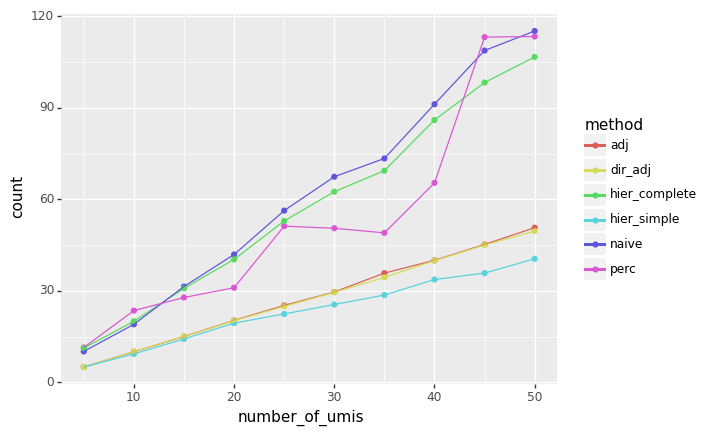

<ggplot: (305133475)>

In [7]:
from plotnine import ggplot, geom_point, aes, stat_smooth, labs

(ggplot(results["number_of_umis"], aes('number_of_umis', 'count', color='factor(dedup)'))
 + geom_point()
 + geom_line()
 + labs(color="method"))